# Tutorial 3 - Generative Models

In this tutorial, you will implement a VAE that learns to generate hand-written digits based on the MNIST dataset you explored yesterday.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## 1.) Define the VAE Model

The model uses an encoder to a 2D bottleneck layer and a decoder back into a 28 x 28 dimensional space

We need to use a trick to train the model despite us adding random gaussian noise. To do that, we use what is called the reparametrization trick: We actually have two maps into two 2D latent spaces: The first one is tasked to learn a map to the mean for a Gaussian distirbution and the second is tasked to learn a map to the variance of a Gaussian distribution. We then use these together as input to the decoder.

In [2]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 400)
        self.fc_mu = nn.Linear(400, 2)        # mean of latent space
        self.fc_logvar = nn.Linear(400, 2)    # log-variance
        self.fc_dec1 = nn.Linear(2, 400)
        self.fc_dec2 = nn.Linear(400, 28 * 28)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc_dec1(z))
        return torch.sigmoid(self.fc_dec2(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

## 2.) Define the loss function

For the loss function, we use two terms:
- the first one is the usual reconstruction loss, i.e., how good the VAE learned the identity
- the second is a "KL Loss" that encourages the output of the encoder to learn to map to a gaussian with 0 mean and unit variance:
    * $0 - \mu^2$ sets the mean to zero
    * $1 - \sigma^2$ sets the variance to one
    * $\log(\sigma^2)$ prevents collapse, i.e. small $\sigma$. Note that for unit variance $\log(\sigma^2)=0$

In [3]:
def vae_loss(x, x_recon, mu, logvar):
    recon_loss = F.binary_cross_entropy(x_recon, x.view(-1, 28 * 28), reduction='sum')
    kl = -0.5 * torch.sum((0 - mu.pow(2)) + (1 - logvar.exp()) + logvar)
    return recon_loss + kl


## 3.) Load the data

We already know the MNIST dataset, so let's just quickly load it in

In [4]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

## 4.) Train the model

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    vae.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(x)
        loss = vae_loss(x, x_recon, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1:3}, Loss: {total_loss / len(train_loader.dataset):.2f}")

Epoch 1, Loss: 190.66
Epoch 2, Loss: 168.48
Epoch 3, Loss: 163.69
Epoch 4, Loss: 160.79
Epoch 5, Loss: 158.76
Epoch 6, Loss: 157.13
Epoch 7, Loss: 155.94
Epoch 8, Loss: 154.94
Epoch 9, Loss: 154.15
Epoch 10, Loss: 153.45


## 5.) Generate some numbers

Each time you rerun this cell, you will get a different number

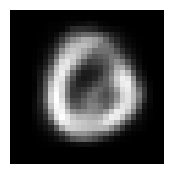

In [22]:
import torch
import matplotlib.pyplot as plt

# Assume your decoder takes a latent vector z and returns an image
# Make sure the model is in eval mode and on the correct device
vae.eval()
z = torch.randn(2, device=device).unsqueeze(0)
with torch.no_grad():
    x_decoded = vae.decode(z).cpu().view(28, 28)
# Plot the resulting canvas
plt.figure(figsize=(2, 2))
plt.imshow(x_decoded.numpy(), cmap="gray")
plt.axis('off')
plt.show()


## 6.) Visualize the 2D Latent Space

We put some images of digits through the encoder and see where their mean gets mapped to. We plot the 2D bottleneck layer of the mean and color the images of the images according to their class (i.e., which handwritten digit they show).

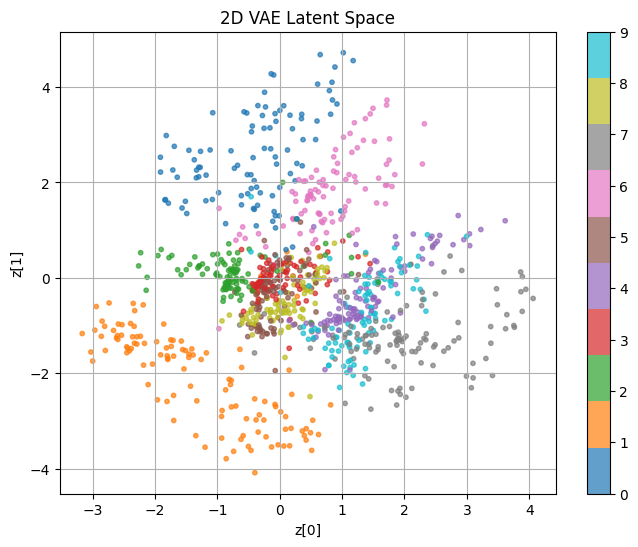

In [15]:
vae.eval()
test_loader = DataLoader(train_dataset, batch_size=1000, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        _, mu, _ = vae(x)
        z = mu.cpu().numpy()
        y = y.numpy()
        break

plt.figure(figsize=(8, 6))
plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10', alpha=0.7, s=10)
plt.colorbar()
plt.title("2D VAE Latent Space")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.grid(True)
plt.show()


We can also see the images that are generated from using the different points in the 2D bottleneck layer as inputs to the decoder

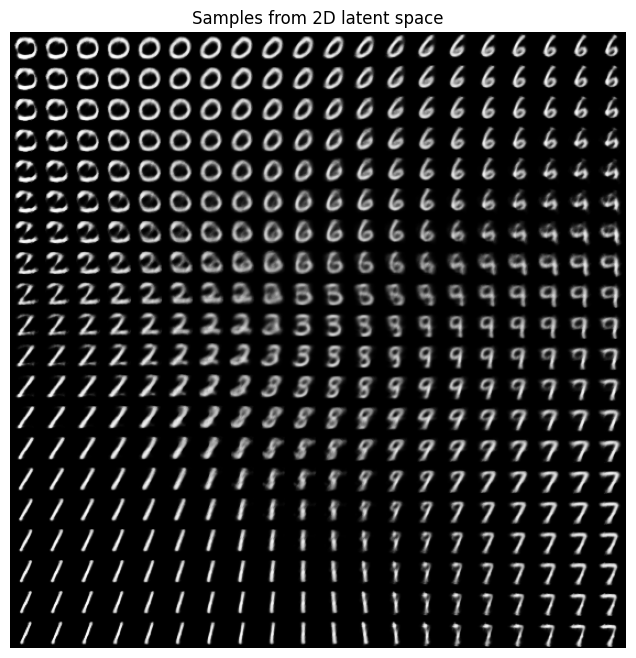

In [13]:
# sample the latent space and generate images
vae.eval()

# Generate a grid of latent vectors
n = 20  # grid size
grid_x = torch.linspace(-3, 3, n)
grid_y = torch.linspace(-3, 3, n)

# Create empty canvas to store the generated images
digit_size = 28
canvas = torch.zeros((digit_size * n, digit_size * n))

# Fill canvas with images decoded from the latent space
for i, yi in enumerate(reversed(grid_y)):
    for j, xi in enumerate(grid_x):
        z = torch.tensor([[xi.item(), yi.item()]], device=device)
        with torch.no_grad():
            x_decoded = vae.decode(z).cpu().view(digit_size, digit_size)
        canvas[i * digit_size:(i + 1) * digit_size,
               j * digit_size:(j + 1) * digit_size] = x_decoded

# Plot the resulting canvas
plt.figure(figsize=(8, 8))
plt.imshow(canvas.numpy(), cmap="gray")
plt.axis('off')
plt.title("Samples from 2D latent space")
plt.show()


# Now it's your turn

I list some suggestions of what you could do below. Pick the one (or ones) that intrest you the most, or just play with the notebook and investigate your own questions.

## Exercise 1: Implement a Fashion MNIST VAE

Modify the code to use the Fashion MNIST dataset and generate some fashion item images

## Exercise 2: Implement a conditional VAE

Write another NN that takes a user input of the number that is to be generated (during training, these would just be the labels). Learn an embedding of this input into the 2D space and add a loss term that aligns the position of the images in latent space with this input. Then the user can "prompt" the model to generate an image of a specific number.